# Genetic Algorithm for Sequential Ordering Problem


In [1]:
import random
import time
import numpy as np
from collections import defaultdict
import os
from pathlib import Path
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt

## The Sequential Ordering Problem


In [ ]:
class SOP:
    def __init__(self, file_path):

        self.file_path = file_path
        self.file_name = Path(file_path).name
        self.nodes, self.costs, self.precedence = self.parse_file(file_path)
        self.size = len(self.nodes)
        
        self.before = defaultdict(set)
        self.after = defaultdict(set)
        self.build_precedence_graph()

    def parse_file(self, file_path):

        with open(file_path, 'r') as f:
            lines = f.readlines()

        dimension = next(int(line.strip().split(':')[1]) 
                         for line in lines if line.startswith('DIMENSION'))
        
        matrix_start = next(i for i, line in enumerate(lines) 
                           if line.startswith('EDGE_WEIGHT_SECTION')) + 1
        
        if lines[matrix_start].strip().isdigit():
            matrix_start += 1
        
        matrix_data = []
        for i in range(matrix_start, matrix_start + dimension):
            row = list(map(int, lines[i].strip().split()))
            matrix_data.append(row)
        
        costs_matrix = np.array(matrix_data)
        
        nodes = list(range(1, dimension + 1))
        costs = {}
        for i in range(dimension):
            for j in range(dimension):
                if costs_matrix[i, j] != -1:
                    costs[(i+1, j+1)] = costs_matrix[i, j]
        
        precedence = []
        for i in range(dimension):
            for j in range(dimension):
                if costs_matrix[i, j] == -1 and i != j:
                    precedence.append((j+1, i+1))
        
        return nodes, costs, precedence

    def build_precedence_graph(self):

        for u, v in self.precedence:
            self.before[v].add(u)
            self.after[u].add(v)
        
        changed = True
        while changed:
            changed = False
            for node in self.nodes:
                old_before = self.before[node].copy()
                for b in old_before:
                    self.before[node].update(self.before[b])
                if len(self.before[node]) > len(old_before):
                    changed = True
                    
                old_after = self.after[node].copy()
                for a in old_after:
                    self.after[node].update(self.after[a])
                if len(self.after[node]) > len(old_after):
                    changed = True

    def is_valid(self, path):
        position = {node: i for i, node in enumerate(path)}
        
        for i, node in enumerate(path):
            for before_node in self.before[node]:
                if before_node in position and position[before_node] >= i:
                    return False
        
        for i in range(len(path) - 1):
            if (path[i], path[i+1]) not in self.costs:
                return False
                
        return True

    def total_cost(self, path):
        
        return sum(self.costs.get((path[i], path[i+1]), float('inf')) 
                  for i in range(len(path) - 1))

## Genetic Algorithm Implementation


In [ ]:
class GeneticSolver:
    def __init__(self, sop, pop_size=50, generations=100, 
                 mutation_rate=0.15, crossover_rate=0.85, 
                 elite_size=5, tournament_size=3,
                 max_stagnation=30):
        self.sop = sop
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elite_size = elite_size
        self.tournament_size = tournament_size
        self.max_stagnation = max_stagnation
        
        self.population = []
        self.best_solution = None
        self.best_cost = float('inf')
        self.last_improvement = 0
        self.generation_stats = []

    def create_initial_population(self):
        
        self.population = []
        
        
        start_candidates = [n for n in self.sop.nodes if not self.sop.before[n]]
        end_candidates = [n for n in self.sop.nodes if not self.sop.after[n]]
        
        start_node = start_candidates[0] if start_candidates else 1
        end_node = end_candidates[0] if end_candidates else self.sop.size
        
        
        greedy_count = int(0.6 * self.pop_size)
        for _ in range(greedy_count):
            path = self.generate_valid_path(start_node, end_node, greedy_bias=0.7)
            if path and path not in self.population:
                self.population.append(path)
                cost = self.sop.total_cost(path)
                if cost < self.best_cost:
                    self.best_cost = cost
                    self.best_solution = path.copy()
        
        
        while len(self.population) < self.pop_size:
            path = self.generate_valid_path(start_node, end_node, greedy_bias=0.3)
            if path and path not in self.population:
                self.population.append(path)
                cost = self.sop.total_cost(path)
                if cost < self.best_cost:
                    self.best_cost = cost
                    self.best_solution = path.copy()

    def generate_valid_path(self, start_node, end_node, greedy_bias=0.5):
        
        path = [start_node]
        remaining = set(self.sop.nodes) - {start_node, end_node}
        
        current_node = start_node
        max_attempts = 100
        attempts = 0
        
        while remaining and attempts < max_attempts:
            candidates = [n for n in remaining if 
                         all(pred not in remaining for pred in self.sop.before[n]) and
                         (current_node, n) in self.sop.costs]
            
            if not candidates:
                attempts += 1
                if attempts >= max_attempts:
                    return None
                path = [start_node]
                remaining = set(self.sop.nodes) - {start_node, end_node}
                current_node = start_node
                continue
                
            costs = [self.sop.costs.get((current_node, n), float('inf')) for n in candidates]
            
            
            if random.random() < greedy_bias:
                
                min_cost = min(costs)
                max_cost = max(costs)
                if min_cost == max_cost:
                    weights = [1] * len(candidates)
                else:
                    weights = [(max_cost - c + 1) / (max_cost - min_cost + 1) for c in costs]
                total = sum(weights)
                weights = [w/total for w in weights]
                next_node = random.choices(candidates, weights=weights, k=1)[0]
            else:
                
                next_node = random.choice(candidates)
            
            path.append(next_node)
            remaining.remove(next_node)
            current_node = next_node
            
        if not remaining:
            path.append(end_node)
            return path
        return None

    def select_parents(self):

        if len(self.generation_stats) > 10:
            costs = [self.sop.total_cost(p) for p in self.population]
            std_dev = np.std(costs)
            if std_dev < (self.best_cost * 0.01):
                
                t_size = max(2, self.tournament_size - 1)
            else:
                t_size = self.tournament_size
        else:
            t_size = self.tournament_size
            
        def tournament():
            candidates = random.sample(range(len(self.population)), t_size)
            return self.population[min(candidates, key=lambda i: self.sop.total_cost(self.population[i]))]
            
        return tournament(), tournament()

    def ordered_crossover(self, parent1, parent2):
        
        if random.random() > self.crossover_rate:
            return parent1.copy()  
            
        size = len(parent1)
        
        
        valid_crossover = False
        max_attempts = 5
        
        for _ in range(max_attempts):
            
            start, end = sorted(random.sample(range(size), 2))
            child = [None] * size
            child[start:end+1] = parent1[start:end+1]
            
            
            remaining = [gene for gene in parent2 if gene not in child[start:end+1]]
            
            
            for i in range(start):
                child[i] = remaining.pop(0)
                
            
            for i in range(end+1, size):
                child[i] = remaining.pop(0)
            
            
            if self.sop.is_valid(child):
                valid_crossover = True
                break
        
        if not valid_crossover:
            
            child = self.repair(child)
            
        return child if child else parent1.copy()

    def repair(self, path):
         
        valid_path = []
        candidates = set(path)
        
        while candidates:
            
            ready = [n for n in candidates 
                    if all(pred not in candidates for pred in self.sop.before[n])]
            
            if not ready:
                
                return None
                
            
            next_node = min(ready, key=lambda n: path.index(n))
            valid_path.append(next_node)
            candidates.remove(next_node)
        
        return valid_path

    def mutate(self, path):

        if random.random() > self.mutation_rate:
            return path
            
        mutated = path.copy()
        size = len(path)
        
        
        op = random.random()
        max_attempts = 10
        
        if op < 0.6:  
            for _ in range(max_attempts):
                i, j = sorted(random.sample(range(size), 2))
                mutated[i], mutated[j] = mutated[j], mutated[i]
                
                if self.sop.is_valid(mutated):
                    return mutated
                
                
                mutated[i], mutated[j] = mutated[j], mutated[i]
                
        elif op < 0.9:  
            for _ in range(max_attempts):
                i = random.randint(0, size-1)
                j = random.randint(0, size-1)
                if i != j:
                    
                    value = mutated.pop(i)
                    mutated.insert(j if j < i else j-1, value)
                    
                    if self.sop.is_valid(mutated):
                        return mutated
                
                
                mutated = path.copy()
                
        else:  
            for _ in range(max_attempts):
                i, j = sorted(random.sample(range(size), 2))
                
                mutated[i:j+1] = reversed(mutated[i:j+1])
                
                if self.sop.is_valid(mutated):
                    return mutated
                
                
                mutated = path.copy()
        
        
        repaired = self.repair(mutated)
        return repaired if repaired else path

    def evolve(self):
        
        sorted_pop = sorted(self.population, 
                          key=lambda p: self.sop.total_cost(p))
        
        
        new_population = sorted_pop[:self.elite_size]
        
        
        while len(new_population) < self.pop_size:
            parent1, parent2 = self.select_parents()
            child = self.ordered_crossover(parent1, parent2)
            child = self.mutate(child)
            
            if child and self.sop.is_valid(child):
                new_population.append(child)
            
        self.population = new_population
        
        
        current_best = min(self.population, key=self.sop.total_cost)
        current_cost = self.sop.total_cost(current_best)
        
        if current_cost < self.best_cost:
            self.best_cost = current_cost
            self.best_solution = current_best.copy()
            self.last_improvement = len(self.generation_stats)
            
        
        costs = [self.sop.total_cost(p) for p in self.population]
        self.generation_stats.append({
            'generation': len(self.generation_stats),
            'best_cost': self.best_cost,
            'avg_cost': np.mean(costs),
            'min_cost': current_cost,
            'diversity': np.std(costs)
        })

    def solve(self, verbose=True):

        start_time = time.time()
        
        self.create_initial_population()
        
        for gen in range(self.generations):
            self.evolve()
            
            if verbose and gen % 10 == 0:
                print(f"Generation {gen}/{self.generations}, " 
                      f"Best cost: {self.best_cost}")
            
            
            if gen - self.last_improvement > self.max_stagnation:
                if verbose:
                    print(f"Early stopping at generation {gen}: no improvement for {self.max_stagnation} generations")
                break
                
        end_time = time.time()
        
        if verbose:
            print(f"\nSolution for {self.sop.file_name}:")
            print(f"Path: {self.best_solution}")
            print(f"Cost: {self.best_cost}")
            print(f"Time: {end_time - start_time:.2f} seconds")
        
        return {
            'instance': self.sop.file_name,
            'solution': self.best_solution,
            'cost': self.best_cost,
            'time': end_time - start_time,
            'generations': len(self.generation_stats),
            'stats': self.generation_stats
        }

## Running the Algorithm


In [4]:
def solve_instance(file_path, pop_size=100, generations=200, verbose=False):
    sop = SOP(file_path)
    solver = GeneticSolver(sop, pop_size=pop_size, generations=generations)
    result = solver.solve(verbose=verbose)
    return result

## Processing Multiple Instances


In [5]:
def process_all_instances(data_dir="GA-ACO-SOPComparison/data/", 
                          instance_names=None, 
                          pop_size=100,
                          generations=200,
                          parallel=False,
                          verbose=True):
    if instance_names is None:
        instance_names = ["ESC07", "ESC11", "ESC12", "ESC25", "ESC47", "ESC63", "ESC78"]
    
    file_paths = [os.path.join(data_dir, f"{name}.sop") for name in instance_names]
    for path in file_paths:
        if not os.path.exists(path):
            print(f"Warning: File {path} not found!")
    
    file_paths = [path for path in file_paths if os.path.exists(path)]
    
    if not file_paths:
        raise FileNotFoundError("No valid SOP files found!")
    
    results = {}
    
    if parallel and len(file_paths) > 1:
        import multiprocessing
        print(f"Processing {len(file_paths)} instances in parallel...")
        with multiprocessing.Pool() as pool:
            args = [(path, pop_size, generations, False) for path in file_paths]
            parallel_results = pool.starmap(solve_instance, args)
            
            for result in parallel_results:
                results[result['instance']] = result
    else:
        for path in file_paths:
            if verbose:
                print(f"\n{'='*50}")
                print(f"Processing {os.path.basename(path)}...")
                print(f"{'='*50}")
            
            result = solve_instance(path, pop_size, generations, verbose)
            results[result['instance']] = result
    
    if verbose:
        print("\n" + "="*70)
        print("Summary of Results:")
        print("="*70)
        print(f"{'Instance':<10} | {'Cost':>10} | {'Time (s)':>10} | {'Generations':>12}")
        print("-"*70)
        for name, result in results.items():
            print(f"{name:<10} | {result['cost']:>10.2f} | {result['time']:>10.2f} | {result['generations']:>12}")
    
    return results


## Saving Results


In [6]:
def save_results(results, output_dir="./results"):
    os.makedirs(output_dir, exist_ok=True)
    
    summary_data = []
    for name, result in results.items():
        summary_data.append({
            'instance': name,
            'cost': result['cost'],
            'time': result['time'],
            'generations': result['generations']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(os.path.join(output_dir, "ga_summary.csv"), index=False)
    
    for name, result in results.items():
        solution_path = os.path.join(output_dir, f"{name}_solution.txt")
        with open(solution_path, 'w') as f:
            f.write(f"Instance: {name}\n")
            f.write(f"Cost: {result['cost']}\n")
            f.write(f"Time: {result['time']:.2f} seconds\n")
            f.write(f"Solution: {result['solution']}\n")
        
        stats_df = pd.DataFrame(result['stats'])
        stats_df.to_csv(os.path.join(output_dir, f"{name}_stats.csv"), index=False)
    
    print(f"Results saved to {output_dir}")

## Convergence Table


In [7]:
def plot_convergence(results, output_dir="./results"):
    plt.figure(figsize=(12, 8))
    
    for name, result in results.items():
        stats = pd.DataFrame(result['stats'])
        plt.plot(stats['generation'], stats['best_cost'], label=name)
    
    plt.xlabel('Generation')
    plt.ylabel('Best Cost')
    plt.title('Convergence of Optimized Genetic Algorithm')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "convergence_plot.png"))
    plt.figure(figsize=(12, 8))
    
    for name, result in results.items():
        stats = pd.DataFrame(result['stats'])
        if 'diversity' in stats.columns:
            plt.plot(stats['generation'], stats['diversity'], label=name)
    
    plt.xlabel('Generation')
    plt.ylabel('Population Diversity')
    plt.title('Population Diversity Over Generations')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "population_diversity_plot.png"))
    plt.close()

def compare_with_original_ga(optimized_results, original_results_path="./results"):

    original_summary = pd.read_csv(os.path.join(original_results_path, "ga_summary.csv"))
    
    comparison_data = []
    
    for name, result in optimized_results.items():
        original_result = original_summary[original_summary['instance'] == name]
        
        if not original_result.empty:
            original_cost = original_result['cost'].values[0]
            original_time = original_result['time'].values[0]
            
            comparison_data.append({
                'instance': name,
                'original_cost': original_cost,
                'optimized_cost': result['cost'],
                'improvement': ((original_cost - result['cost']) / original_cost) * 100,
                'original_time': original_time,
                'optimized_time': result['time'],
                'time_ratio': result['time'] / original_time
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n" + "="*80)
    print("Comparison with Original GA:")
    print("="*80)
    print(f"{'Instance':<10} | {'Original Cost':>12} | {'Optimized Cost':>14} | {'Improvement %':>13} | {'Time Ratio':>10}")
    print("-"*80)
    
    for _, row in comparison_df.iterrows():
        print(f"{row['instance']:<10} | {row['original_cost']:>12.2f} | {row['optimized_cost']:>14.2f} | {row['improvement']:>13.2f}% | {row['time_ratio']:>10.2f}")
    
    avg_improvement = comparison_df['improvement'].mean()
    print(f"\nAverage improvement over original GA: {avg_improvement:.2f}%")
    
    return comparison_df


## Main



Processing ESC07.sop...
Generation 0/200, Best cost: 2125
Generation 10/200, Best cost: 2125
Generation 20/200, Best cost: 2125
Generation 30/200, Best cost: 2125
Early stopping at generation 31: no improvement for 30 generations

Solution for ESC07.sop:
Path: [1, 2, 5, 8, 3, 7, 6, 4, 9]
Cost: 2125
Time: 0.88 seconds

Processing ESC11.sop...
Generation 0/200, Best cost: 2892
Generation 10/200, Best cost: 2397
Generation 20/200, Best cost: 2397
Generation 30/200, Best cost: 2397
Generation 40/200, Best cost: 2262
Generation 50/200, Best cost: 2262
Generation 60/200, Best cost: 2262
Early stopping at generation 62: no improvement for 30 generations

Solution for ESC11.sop:
Path: [1, 11, 8, 9, 12, 5, 2, 10, 3, 6, 4, 7, 13]
Cost: 2262
Time: 2.76 seconds

Processing ESC12.sop...
Generation 0/200, Best cost: 2016
Generation 10/200, Best cost: 1751
Generation 20/200, Best cost: 1751
Generation 30/200, Best cost: 1751
Early stopping at generation 36: no improvement for 30 generations

Solutio

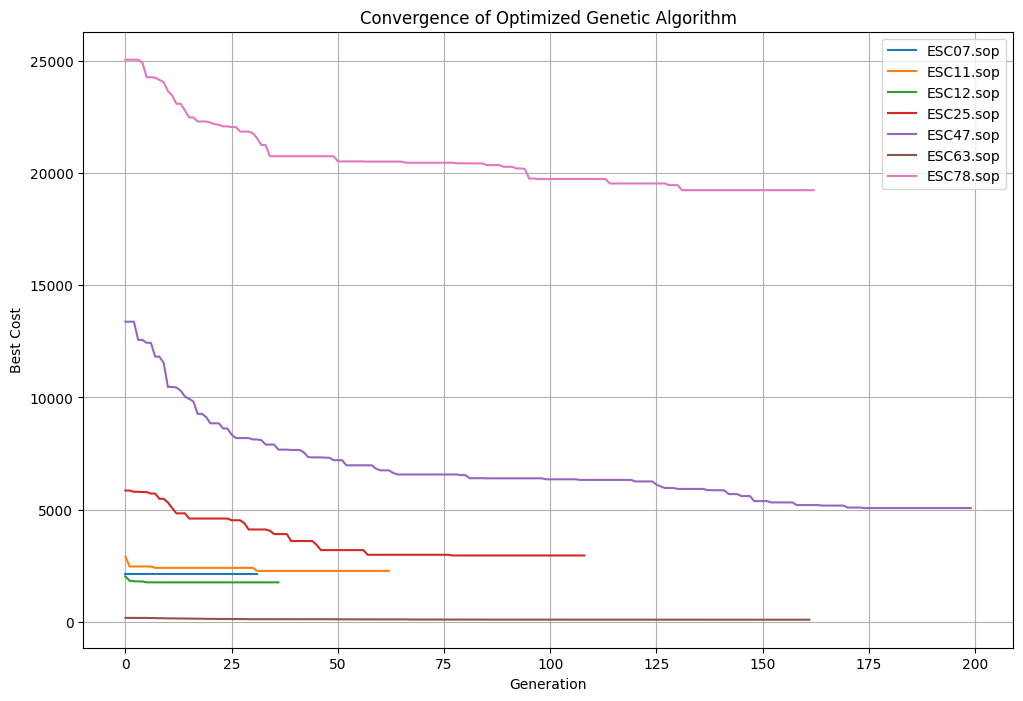

In [8]:
if __name__ == "__main__":
    instances = ["ESC07", "ESC11", "ESC12", "ESC25", "ESC47", "ESC63", "ESC78"]
    
    results = process_all_instances(
        data_dir="../data",  
        instance_names=instances,
        pop_size=100,      
        generations=200,   
        parallel=False,    
        verbose=True      
    )
    
    save_results(results, output_dir="./results")
    plot_convergence(results, output_dir="./results")
    
    print("\nFinal Results Summary:")
    for name, result in results.items():
        print(f"Instance: {name}, Best Cost: {result['cost']}")
